In [1]:
import os
import cv2
import shutil
import random
import numpy as nptw
import pandas as pd
from PIL import Image
import tensorflow as tf
from matplotlib import pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, GlobalMaxPooling2D
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model

# Suppressing warnings
import warnings
warnings.filterwarnings("ignore")

In [11]:
metadata = pd.read_csv("HAM10000_metadata.csv")
metadata.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


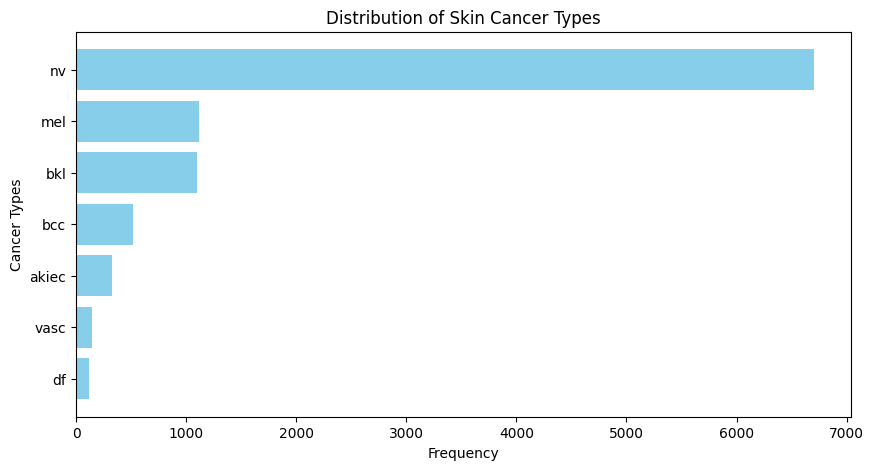

In [12]:
cancer_type_counts = metadata['dx'].value_counts()
plt.figure(figsize=(10, 5))
plt.barh(cancer_type_counts.index, cancer_type_counts.values, color='skyblue')
plt.title('Distribution of Skin Cancer Types')
plt.xlabel('Frequency')
plt.ylabel('Cancer Types')
plt.gca().invert_yaxis()  # Invert y-axis to have the highest frequency at the top
plt.show()

In [4]:
encoder = LabelEncoder()
metadata["dx_label"] = encoder.fit_transform(metadata["dx"])
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

['akiec' 'bcc' 'bkl' 'df' 'mel' 'nv' 'vasc']
[0 1 2 3 4 5 6]


In [5]:
dir_names = encoder.transform(encoder.classes_)

images_dir = r"images"
train_images_dir = r"train_images"


def create_dirs(dir_path:str, dir_names:list):
    for dir_name in dir_names:
        try:
            os.makedirs(os.path.join(dir_path, str(dir_name)))
        except FileExistsError:
            continue


create_dirs(train_images_dir, dir_names)

for image in os.scandir(images_dir):
    try:
        img_name = image.name.split(".")[0]
        img_cancer_type = str(metadata.dx_label[metadata.image_id == img_name].item()) # Retrieving the dx_label for image.
        shutil.copy(os.path.join(images_dir, image.name), os.path.join(train_images_dir, img_cancer_type, image.name))
    except Exception as e:
        print(e)

In [19]:
test_images_dir = r"test_images"
inds = [] 
twenty_percent_content = {}
for dir_name in os.scandir(train_images_dir): 
    for cancer_img in os.scandir(dir_name):
        inds.append(cancer_img.path.split("\\")[1]) 

for directory in dir_names:
    total_amt = inds.count(str(directory))
    c_type = encoder.inverse_transform([int(directory)])[0]
    twenty_percent_content[str(directory)] = round(total_amt * 0.20, 0)


create_dirs(test_images_dir, dir_names)


for sub_dir in os.scandir(train_images_dir):
    images_paths = [image.path for image in os.scandir(sub_dir)]
    for image_path in images_paths[: int(twenty_percent_content[str(sub_dir.name)])]:
        image_category = image_path.split("\\")[1]
        shutil.move(image_path, os.path.join(test_images_dir, image_category, image_path.split("\\")[-1]))

In [2]:

images_dir = r"images"
train_images_dir = r"train_images"
test_images_dir = r"test_images"

img_size = 250
batch_size = 32

generator = ImageDataGenerator(zoom_range = 0.3,
                               rotation_range = 90,
                               horizontal_flip = True,
                               vertical_flip = True,
                               validation_split = 0.1,)
train_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = batch_size,
                            subset = "training")

validation_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = 32,
                            subset = "validation")

test_data = generator.flow_from_directory(
                            test_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = batch_size,
                            subset = "validation")

Found 7213 images belonging to 7 classes.
Found 799 images belonging to 7 classes.
Found 198 images belonging to 7 classes.


In [3]:
from tensorflow.keras.applications import ResNet50
from keras import Model
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

for layer in resnet_model.layers:
    layer.trainable = False

resnet_model.summary()
last_layer = resnet_model.get_layer('conv5_block3_out')
last_output = last_layer.output

x = GlobalAveragePooling2D()(last_output)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(7, activation='softmax')(x)
model = Model(resnet_model.input, x)
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 250, 250,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 256, 256,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 125, 125,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 125, 125,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 125, 125,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 127, 127,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 63, 63,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 63, 63,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 63, 63,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 63, 63,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 63, 63,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 63, 63,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 63, 63,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 63, 63,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 63, 63,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 63, 63,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 63, 63,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
history = model.fit(
    train_data,
    validation_data=validation_data,
    epochs=10
)

Epoch 1/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.6434 - loss: 1.1542 - val_accuracy: 0.7247 - val_loss: 0.7554
Epoch 2/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.7235 - loss: 0.7729 - val_accuracy: 0.7234 - val_loss: 0.7411
Epoch 3/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.7332 - loss: 0.7368 - val_accuracy: 0.7359 - val_loss: 0.7140
Epoch 4/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.7370 - loss: 0.7115 - val_accuracy: 0.7522 - val_loss: 0.7083
Epoch 5/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.7460 - loss: 0.7034 - val_accuracy: 0.7547 - val_loss: 0.6534
Epoch 6/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.7528 - loss: 0.6935 - val_accuracy: 0.7722 - val_loss: 0.6576
Epoch 7/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 511s 2s/step - accuracy: 0.7425 - loss: 0.6956 - val_accuracy: 0.7572 - val_loss: 0.6772
Epoch 8/10
226/226 ━━━━━━━━━━━━━━━━━━━━ 513s 2s/step - accuracy: 0.7496 - loss: 0.6813 - val_accu

In [5]:
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

for layer in resnet_model.layers:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['acc'])
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=2)

In [6]:
epochs = 20
history = model.fit(train_data,
                              epochs = epochs, validation_data = validation_data,
                              verbose = 1, 
                              callbacks=[learning_rate_reduction])

Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 2202s 10s/step - acc: 0.7397 - loss: 0.7684 - val_acc: 0.7359 - val_loss: 1.1166 - learning_rate: 1.0000e-04
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 2148s 9s/step - acc: 0.7961 - loss: 0.5652 - val_acc: 0.7922 - val_loss: 0.6638 - learning_rate: 1.0000e-04
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 2152s 10s/step - acc: 0.8184 - loss: 0.4914 - val_acc: 0.7622 - val_loss: 0.8248 - learning_rate: 1.0000e-04
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 2136s 9s/step - acc: 0.8426 - loss: 0.4488 - val_acc: 0.8123 - val_loss: 0.5551 - learning_rate: 1.0000e-04
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 2133s 9s/step - acc: 0.8517 - loss: 0.3891 - val_acc: 0.7660 - val_loss: 0.8572 - learning_rate: 1.0000e-04
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 2147s 9s/step - acc: 0.8643 - loss: 0.3729 - val_acc: 0.7635 - val_loss: 0.9408 - learning_rate: 1.0000e-04
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - acc: 0.8703 - loss: 0.3421
Epoch 7: ReduceLROnPlateau red

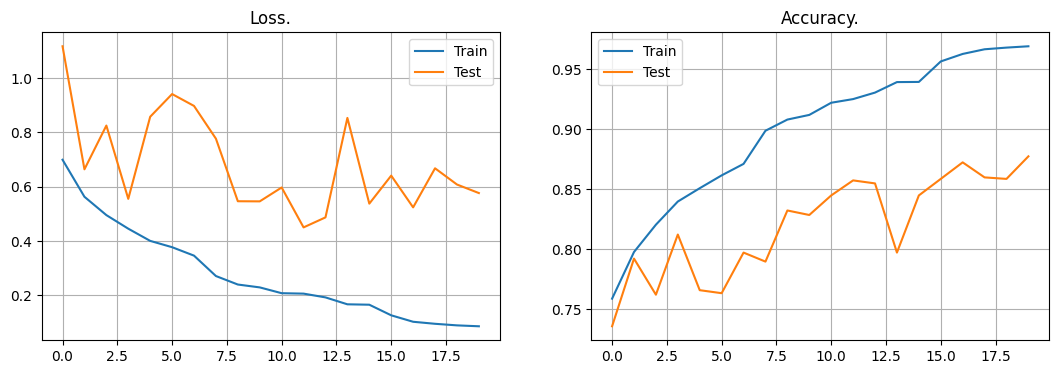

In [9]:
metrics = history.history

train_loss = metrics["loss"]
train_accuracy = metrics["acc"]

test_loss = metrics["val_loss"]
test_accuracy = metrics["val_acc"]

plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train")
plt.plot(test_loss, label = "Test")
plt.grid(True)
plt.legend(loc = "best")

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train")
plt.plot(test_accuracy, label = "Test")
plt.grid(True)
plt.legend(loc = "best")

In [8]:
model.save('resnet.keras')

In [10]:
from tensorflow.keras.optimizers import Adam

custom_optimizer = Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    decay=0.0,
    amsgrad=False
)

model = tf.keras.models.load_model('resnet.keras', compile=False)

model.compile(
    loss='categorical_crossentropy',
    optimizer=custom_optimizer,
    metrics=['acc']
)

In [11]:
test_loss, test_accuracy = model.evaluate(test_data)

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_accuracy}')

7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - acc: 0.8953 - loss: 0.4361
Test Loss: 0.3800683915615082
Test Accuracy: 0.9040403962135315
